In [1]:
from PIL.Image import *
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import misc
import time
import itertools
import multiprocessing
import operator
from numpy import linalg as LA

In [3]:
list_dir=[]
list_shapes=[]
root_adress="Fishes/"
for i in next(os.walk(root_adress))[1]:
    if i!=".ipynb_checkpoints":
        list_dir.append(root_adress+i)
list_dir=list_dir[:-1]
        
for i in list_dir:
    first_file=np.expand_dims(misc.imread(i+'/'+os.listdir(i)[0])[:,:,0],0)
    list_shapes.append(first_file.shape)
    print(first_file.shape)

shapes0=[len(os.listdir(i)) for i in list_dir]    
min_shape0=min(shapes0)
min_shape1=min(list_shapes,key= lambda x:x[1])[1]
min_shape2=min(list_shapes,key= lambda x:x[2])[2]
print(min_shape0,min_shape1,min_shape2)


for it,repo in enumerate(list_dir):
    files_list=sorted(os.listdir(repo))
    files_list=[files_list[i] for i in range(len(files_list)) if i%int(shapes0[it]/min_shape0)==0]
    images_list=[np.expand_dims(misc.imread(repo+"/"+f)[:,:,0],0) for f in files_list]
    volume=np.concatenate(images_list)
    volume=volume[:,np.arange(0,volume.shape[1],int(volume.shape[1]/min_shape1)),:]
    volume=volume[:,:min_shape1,:]
    volume=volume[:,:,np.arange(0,volume.shape[2],int(volume.shape[2]/min_shape2))]
    volume=volume[:,:,:min_shape2]
    print(volume.shape)
    if it==0:
        whole_volume=volume
    else:
        whole_volume=np.concatenate((whole_volume,volume),axis=0)
volume=whole_volume.copy()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.


(1, 1286, 372)
(1, 1173, 212)
(224, 1173, 212)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


(285, 1173, 212)
(224, 1173, 212)


In [4]:
whole_volume=whole_volume[np.arange(0,whole_volume.shape[0],8),:,:]
whole_volume=whole_volume[:,np.arange(0,whole_volume.shape[1],8),:]
whole_volume=whole_volume[:,:,np.arange(0,whole_volume.shape[2],8)]

In [5]:
%load_ext Cython

In [6]:
%%cython
import numpy as np
cimport numpy as np
import itertools
import time

# return the indices of the adjacents vertices
def get_neighbors(int x, int y, int z,np.ndarray array,factor):
    index_list=[]
    cdef int i=0;
    cdef int j=0;
    cdef int k=0;
    cdef int shape0=array.shape[0]
    cdef int shape1=array.shape[1]
    cdef int shape2=array.shape[2]
    for i in range(x-factor,x+factor+1):
        if i>=0 and i<shape0:
            for j in range(y-factor,y+factor+1):
                if j>=0 and j<shape1:
                    for k in range(z-factor,z+factor+1):
                        if k>=0 and k<shape2:
                            if not(i==x and j==y and k==z):
                                index_list.append((i,j,k))
    return index_list

# return the upper link of a vertex (the neighbour which have a greater function than you)
cdef list upper_link(int x, int y, int z,np.ndarray array):
    cdef float value=array[x,y,z]
    index_list=[]
    cdef int i=0;
    cdef int j=0;
    cdef int k=0;
    cdef int shape0=array.shape[0]
    cdef int shape1=array.shape[1]
    cdef int shape2=array.shape[2]
    for i in range(x-1,x+2):
        if i>=0 and i<shape0:
            for j in range(y-1,y+2):
                if j>=0 and j<shape1:
                    for k in range(z-1,z+2):
                        if k>=0 and k<shape2:
                            if not(i==x and j==y and k==z):
                                if (i==x or j==y or k==z):
                                    if (array[i,j,k]>value):
                                        index_list.append([i,j,k])
                                    elif (array[i,j,k]==value):    
                                        if i>x:
                                            index_list.append([i,j,k])
                                        elif i==x:
                                            if j>y:
                                                index_list.append([i,j,k])
                                            elif j==y:
                                                if k>z:
                                                    index_list.append([i,j,k])

    return index_list

# return the value and the position of each cell of the array
cdef list get_indexes(np.ndarray array):
    cdef list indexes=[]
    for i in range(0,array.shape[0]):
        for j in range(0,array.shape[1]):
            for k in range(0,array.shape[2]):
                indexes.append([array[i,j,k],[i,j,k]])
    return indexes    


# main function which computes the join tree
def hierarchical_segmentation(array):
    indexes=get_indexes(array)
    a=[d[0] for d in indexes]
    b=[d[1][0] for d in indexes]
    c=[d[1][1] for d in indexes]
    d=[d[1][2] for d in indexes]
#     sort the indexes by decreasing function value
    lala=np.lexsort((d,c,b,a))
    indexes=[[a[tmp],[b[tmp],c[tmp],d[tmp]]] for tmp in lala]
    indexes=indexes[::-1]
    topological_array=np.ones(array.shape)
    topological_propagate=np.ones(array.shape)
    topological_propagate[topological_propagate==1]=-1
    topological_array[topological_array==1]=-1
    count=0
    maximum_set=set()
    parent_dict={}
    cdef int i=0;
    print("Entering the loop")
    for i in range(len(indexes)):
        value=indexes[i][0]
        a=indexes[i][1][0]
        b=indexes[i][1][1]
        c=indexes[i][1][2]
        
#         for each vertex, we compute the upper link
        index_list=upper_link(a,b,c,array)
        tmp=[topological_propagate[tmp[0],tmp[1],tmp[2]] for tmp in index_list]
        dict_key=set(tmp)
#         if it's empty the we create a new component
        if len(dict_key)==0:
            topological_array[a,b,c]=count
            topological_propagate[a,b,c]=count
            maximum_set.add(count)
            count+=1
#         if if only contains one component (regular point) then we add the point to the existing component
#         we don't create a new one
        elif len(dict_key)==1:
            topological_array[a,b,c]=topological_propagate[index_list[0][0],index_list[0][1],index_list[0][2]]
            topological_propagate[a,b,c]=topological_propagate[index_list[0][0],index_list[0][1],index_list[0][2]]
#         if the upper link contains more than two components then, we create a new one which englobes all the neighbours one
        else:        
            topological_propagate[a,b,c]=count
            topological_array[a,b,c]=count
            for j in dict_key:
                parent_dict[j]=count
                topological_propagate[topological_propagate==j]=count
            count+=1
    return topological_array,maximum_set,parent_dict

In [7]:
# how we mesure a component
def set_w(a,topological_array,x,inverse_dict):
    volume=float(np.sum(a[topological_array==x]))
    return volume

# for each component of the tree we compute w
def compute_w(a,topological_array,inverse_dict):
    w={}
    for i in np.unique(topological_array):
        w[i]=set_w(a,topological_array,i,inverse_dict)
    return w


def compute_sorted_x(maximum_set,w,parent_dict,topological_array,a):
    sorted_x=[]
    for i in maximum_set:
        sorted_x=compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a)
    return sorted_x

def compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a):
    if i in parent_dict:
        j=parent_dict[i]
        if i in w and j in w:
                sorted_x.append(((i,j),w[i],
                                 np.sum(np.abs(np.mean(np.argwhere(topological_array==i),axis=0)-np.mean(np.argwhere(topological_array==j),axis=0)))))
    return sorted_x
    
def single_tree_simplification(w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict,array):
#     we sort all the maximum components we can remove
    tmp1=[i[1] for i in sorted_x]
    tmp2=[i[2] for i in sorted_x]
    lala=np.lexsort((tmp2,tmp1))
#     we delete the smallest one
    maximum,saddle=sorted_x[lala[0]][0]
    if maximum in maximum_set:
        regular_2_list=[maximum]
        maximum_set.remove(maximum)
#         we replace all the place where this maximum component appears by his saddle parent
        topological_array[topological_array==maximum]=saddle
        w[saddle]=set_w(a,topological_array,saddle,inverse_dict)
        i=saddle
        intersection=[(topological_array==j).sum() for j in inverse_dict[i]]
        intersection_sum=np.count_nonzero(intersection)
        if intersection_sum==0:
            maximum_set.add(i)
            sorted_x=compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a)        
        elif intersection_sum==1:
            old_maximum=[j for j in inverse_dict[i] if ((topological_array==j).sum()!=0)][0]
            if old_maximum in maximum_set:
                maximum_set.remove(old_maximum)
                topological_array[topological_array==old_maximum]=i
                w[i]=set_w(a,topological_array,i,inverse_dict)
                regular_2_list.append(old_maximum)
                maximum_set.add(i)
                sorted_x=compute_sorted_x2(sorted_x,maximum_set,w,parent_dict,topological_array,i,a)                
                
    sorted_x.pop(lala[0])
    return w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict

In [9]:
a=whole_volume
time1=time.time()
# we compute the join tree
topological_array,maximum_set,parent_dict=hierarchical_segmentation(a)
time2=time.time()
print(time2-time1)
inverse_dict={}
for i in parent_dict:
    if parent_dict[i] not in inverse_dict:
        inverse_dict[parent_dict[i]]=set([i])
    else:
        inverse_dict[parent_dict[i]].add(i)
# compute the measure of each component
w=compute_w(a,topological_array,inverse_dict)
# add in a list all the maximum component that can be merged with their respective parent
sorted_x=compute_sorted_x(maximum_set,w,parent_dict,topological_array,a)

Entering the loop
19.1503009796


(19095, 9762, 9758)
(18994, 9671, 9666)
(18894, 9571, 9566)
(18789, 9476, 9466)
(18688, 9382, 9371)
(18589, 9285, 9275)
(18491, 9187, 9179)
(18384, 9100, 9085)
(18264, 9026, 8991)
(18154, 8944, 8899)
(18048, 8853, 8802)
(17938, 8768, 8707)
(17827, 8682, 8610)
(17712, 8600, 8513)
(17574, 8543, 8418)
(17469, 8450, 8320)
(17362, 8369, 8232)
(17242, 8301, 8144)
(17142, 8201, 8044)
(17009, 8150, 7960)
(16905, 8057, 7863)


/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(16802, 7980, 7783)
(16695, 7892, 7688)
(16593, 7813, 7607)
(16485, 7730, 7516)
(16378, 7644, 7423)
(16270, 7554, 7325)
(16149, 7480, 7230)
(16043, 7390, 7134)
(15943, 7290, 7034)
(15823, 7218, 6942)
(15695, 7152, 6848)
(15588, 7060, 6749)
(15488, 6960, 6649)
(15361, 6895, 6557)
(15233, 6833, 6467)
(15110, 6763, 6374)
(15009, 6664, 6274)
(14889, 6590, 6180)
(14764, 6529, 6094)
(14631, 6475, 6007)
(14516, 6391, 5908)
(14400, 6312, 5813)
(14267, 6259, 5727)
(14128, 6206, 5635)
(14027, 6107, 5535)
(13901, 6051, 5453)
(13783, 5984, 5368)
(13675, 5907, 5283)
(13557, 5851, 5209)
(13449, 5771, 5121)
(13357, 5690, 5048)
(13264, 5603, 4968)
(13160, 5522, 4883)
(13058, 5439, 4798)
(12973, 5350, 4724)
(12867, 5271, 4639)
(12769, 5193, 4563)
(12678, 5109, 4488)
(12576, 5025, 4402)
(12473, 4937, 4311)
(12376, 4851, 4228)
(12270, 4771, 4142)
(12159, 4697, 4057)
(12052, 4625, 3978)
(11958, 4545, 3904)
(11872, 4460, 3833)
(11780, 4380, 3761)
(11680, 4302, 3683)
(11595, 4220, 3616)
(11501, 4143, 3545)


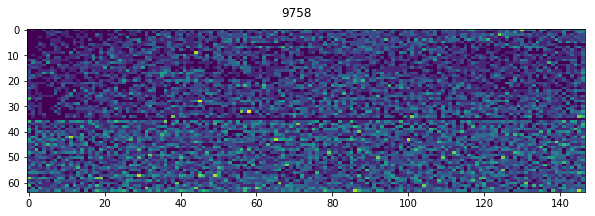

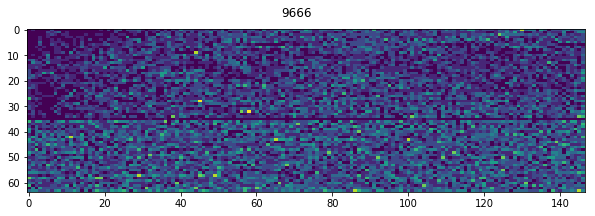

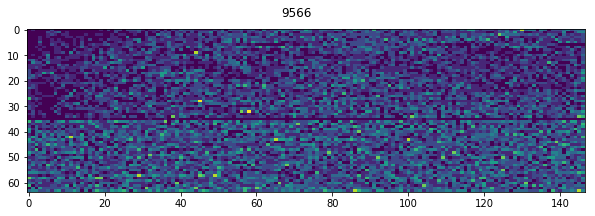

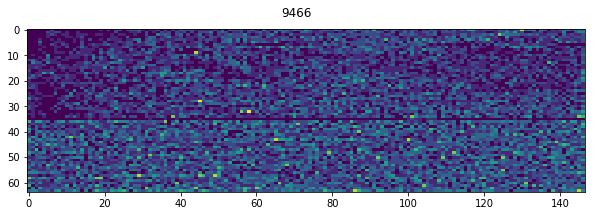

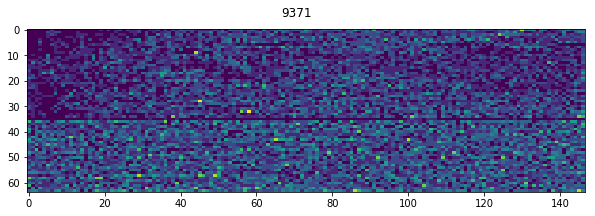

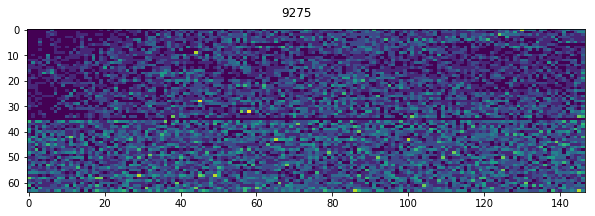

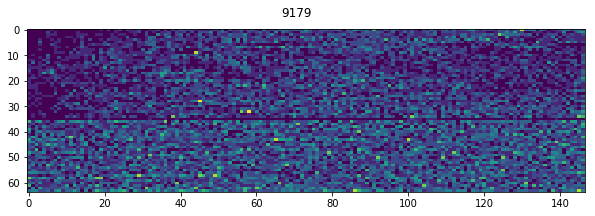

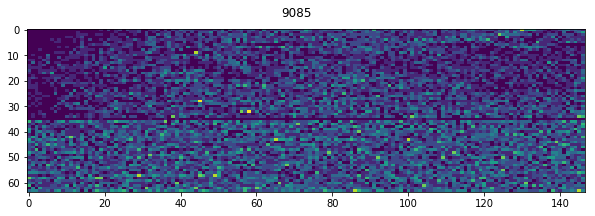

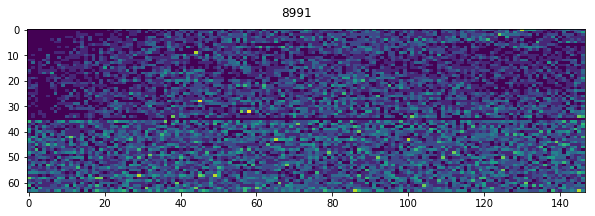

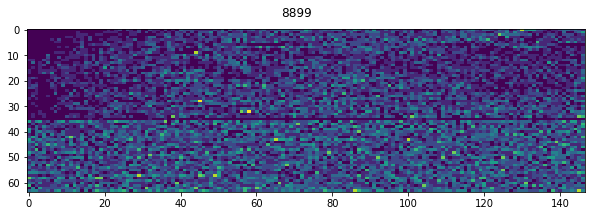

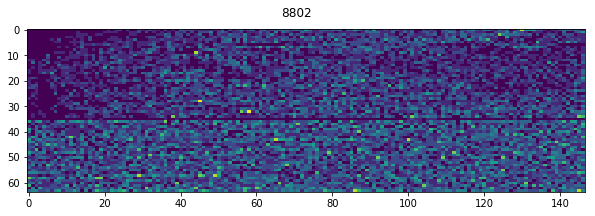

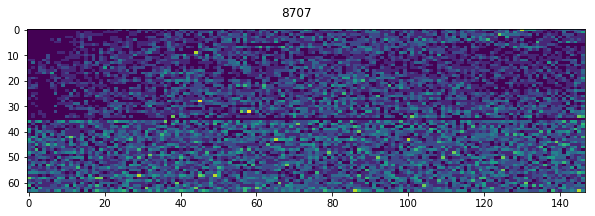

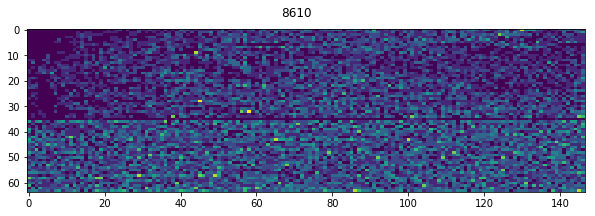

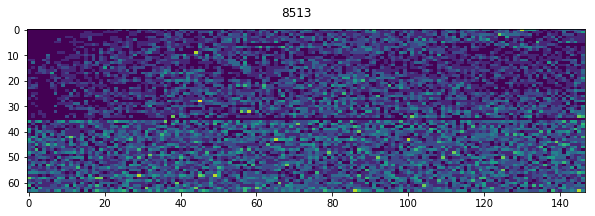

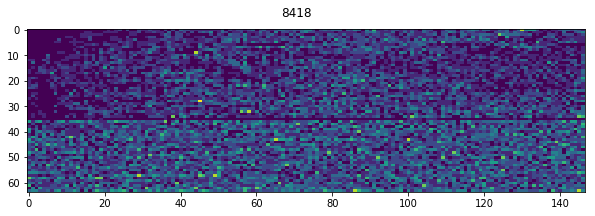

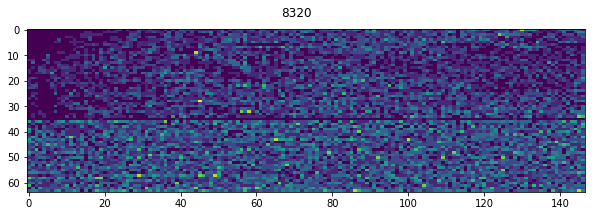

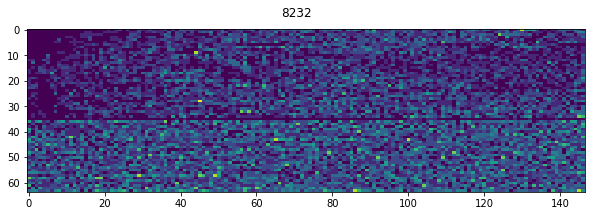

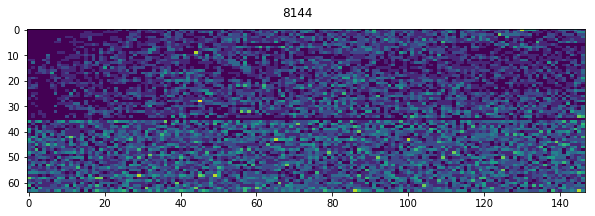

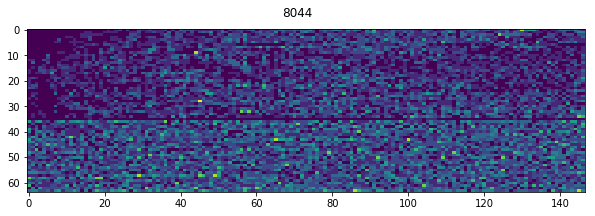

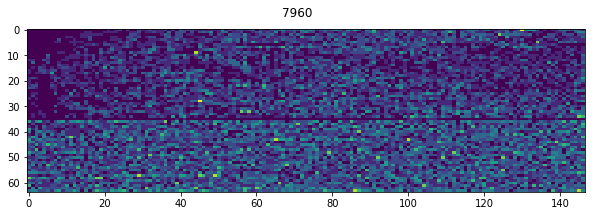

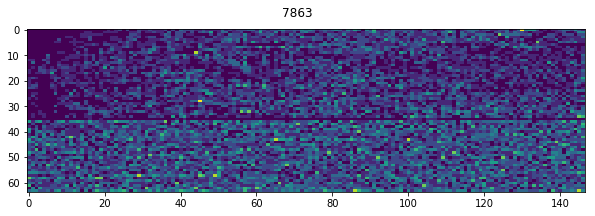

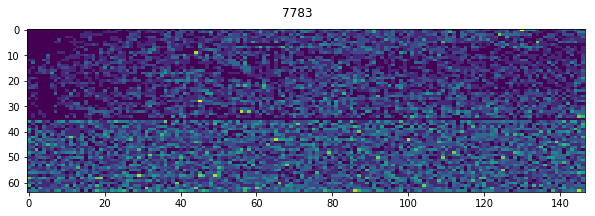

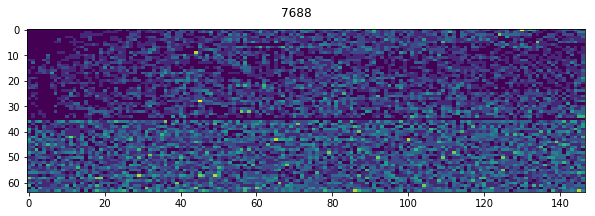

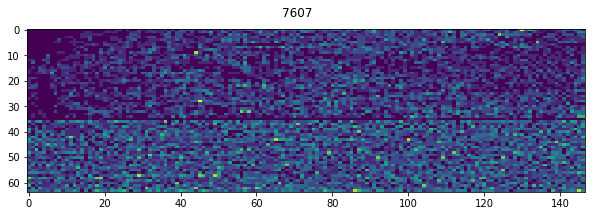

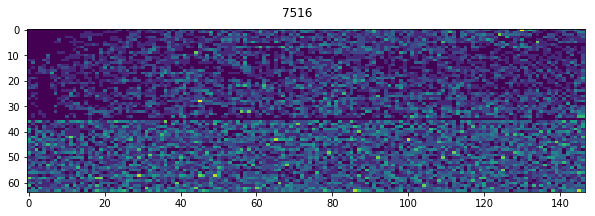

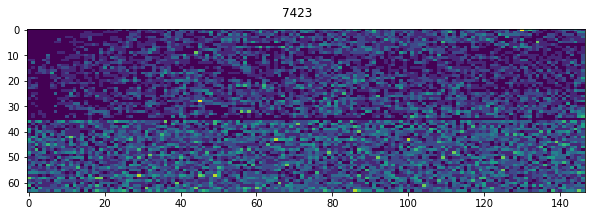

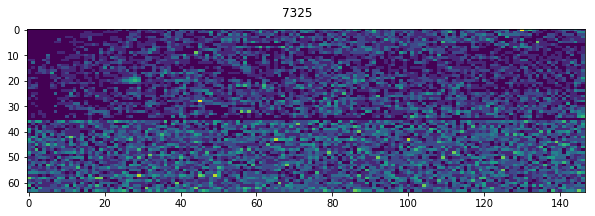

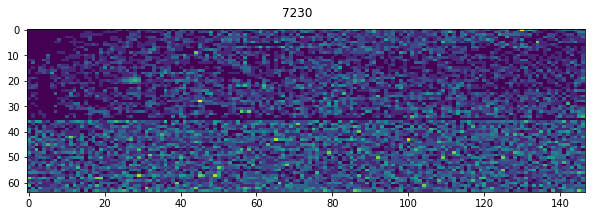

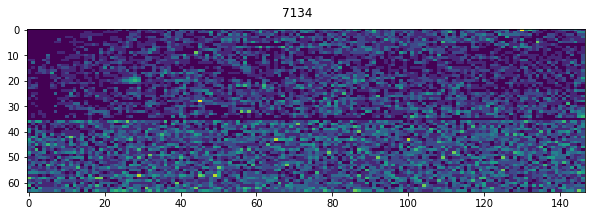

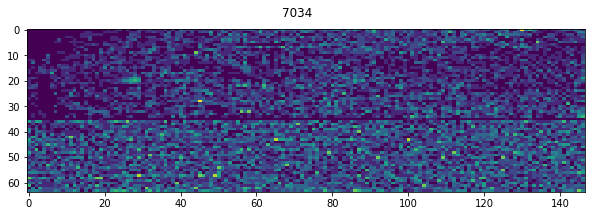

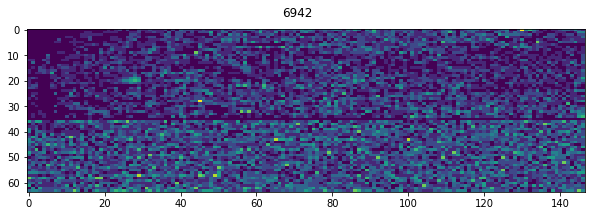

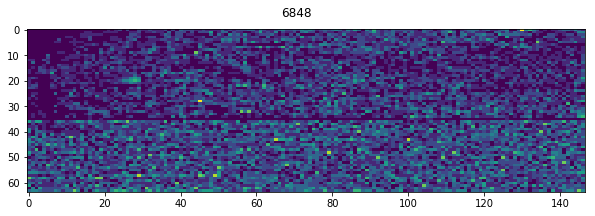

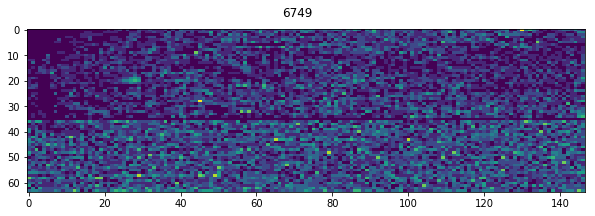

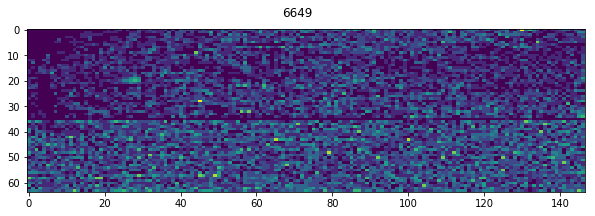

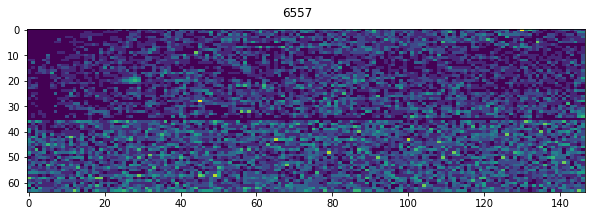

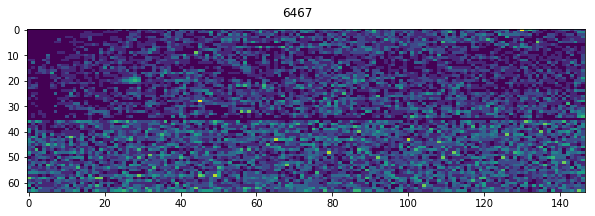

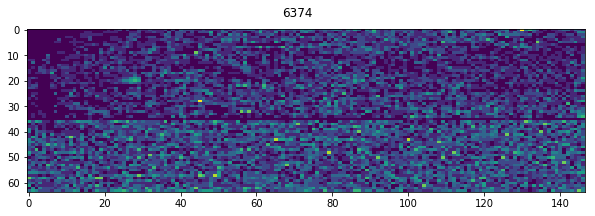

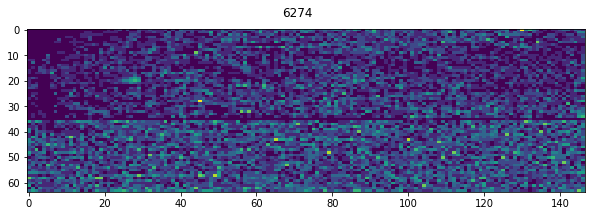

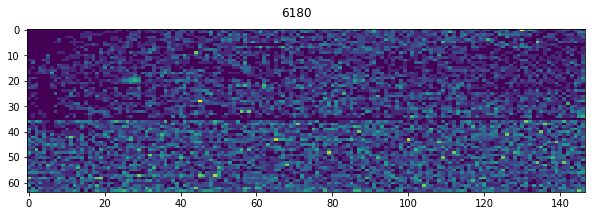

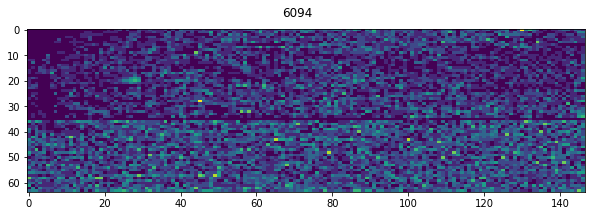

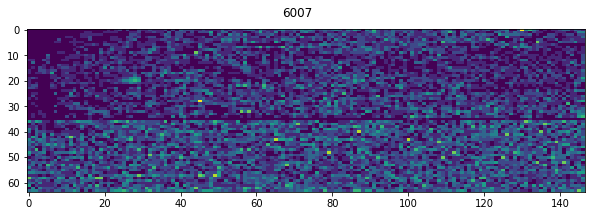

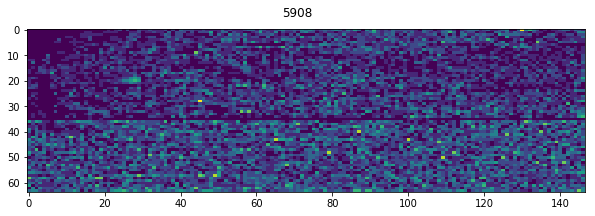

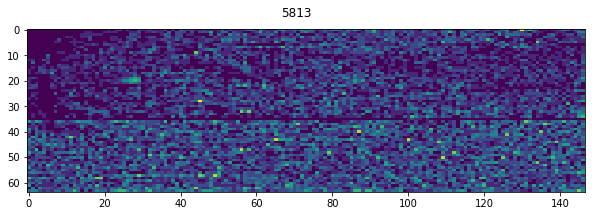

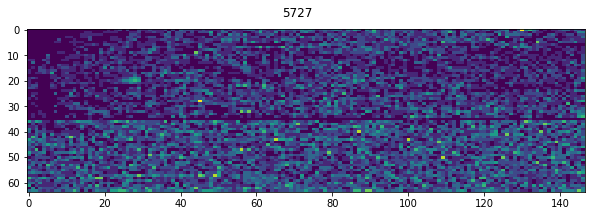

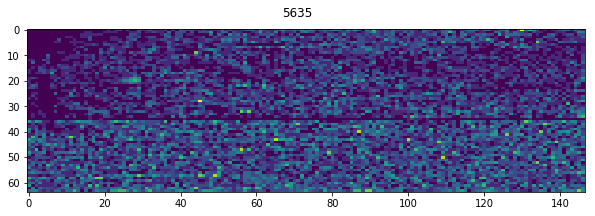

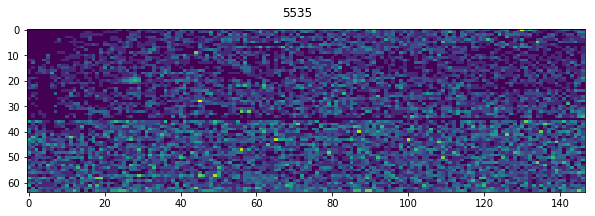

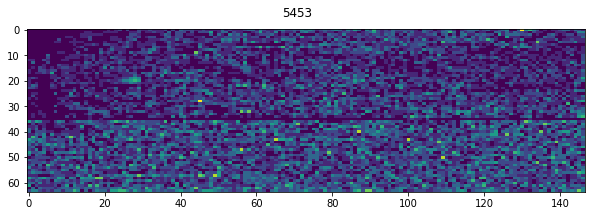

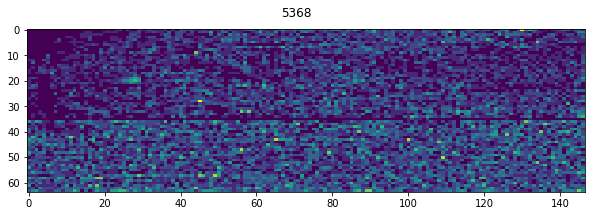

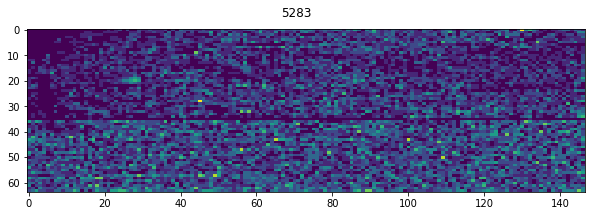

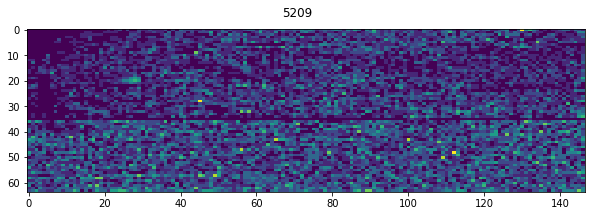

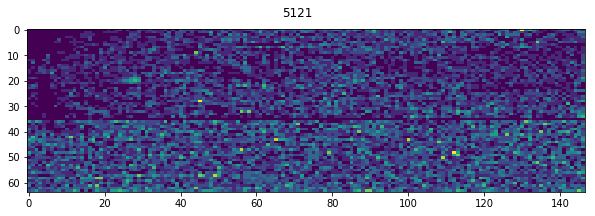

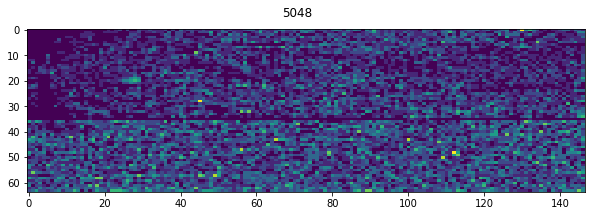

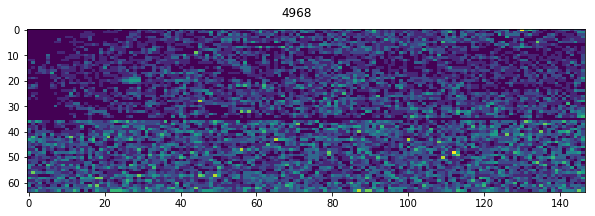

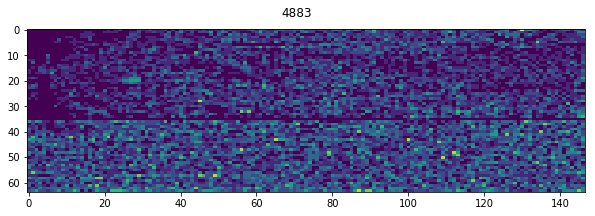

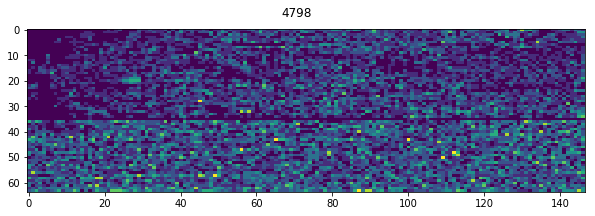

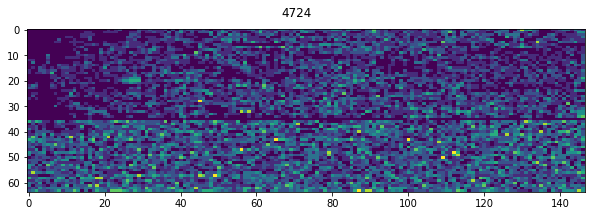

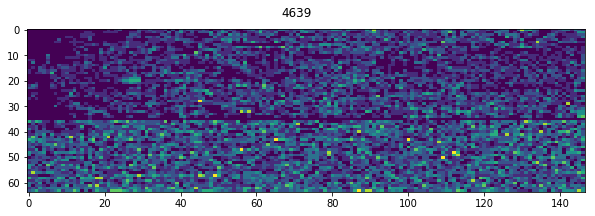

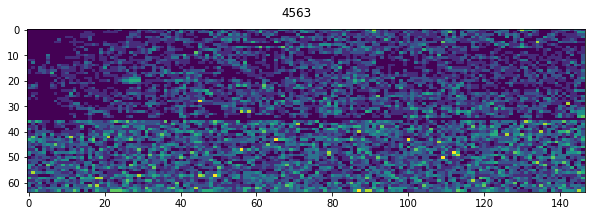

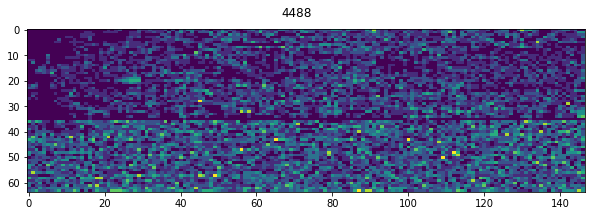

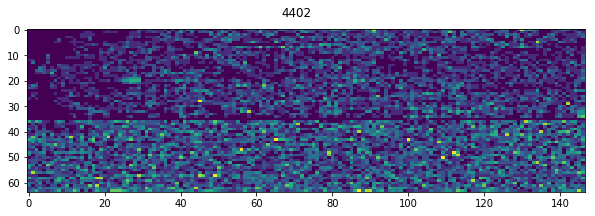

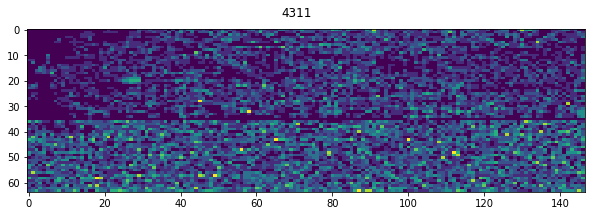

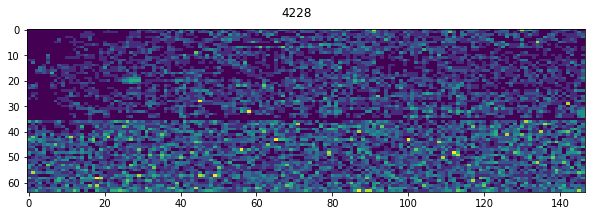

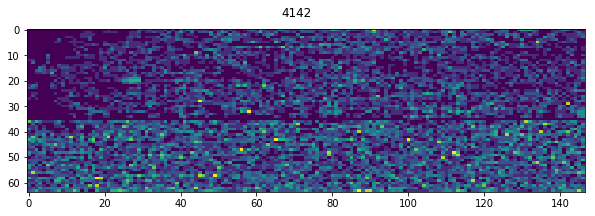

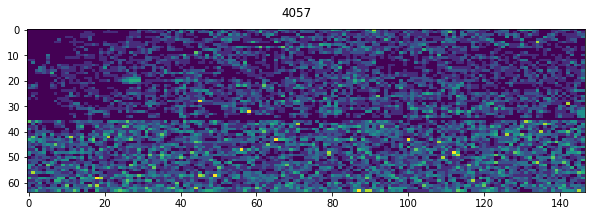

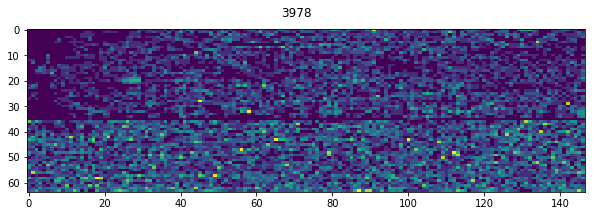

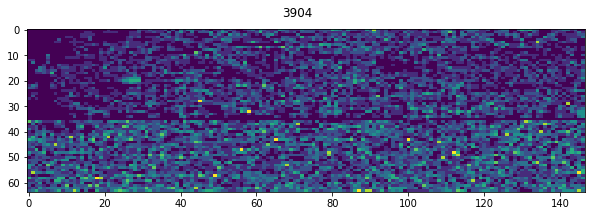

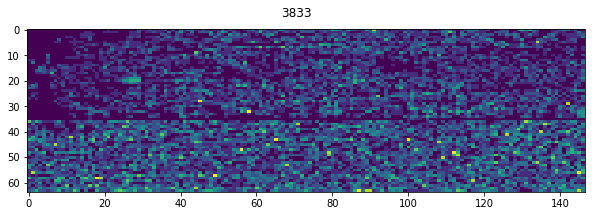

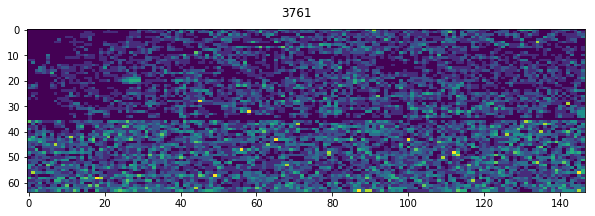

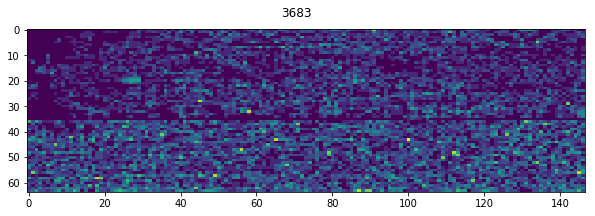

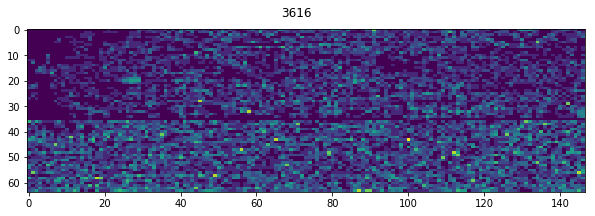

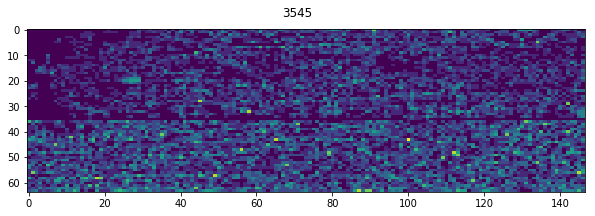

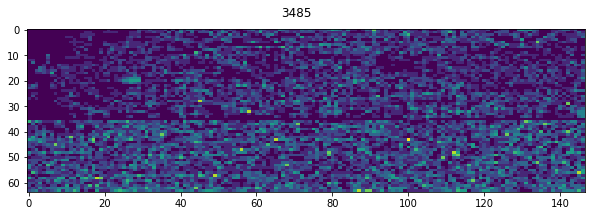

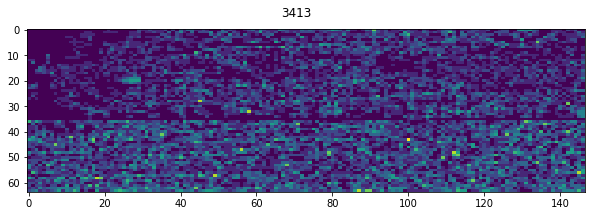

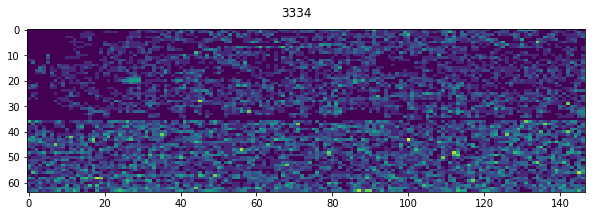

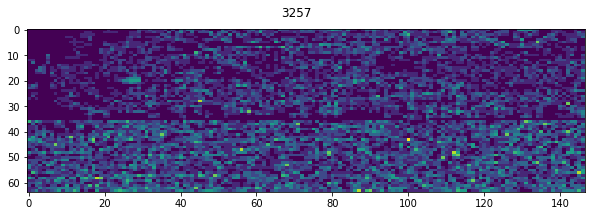

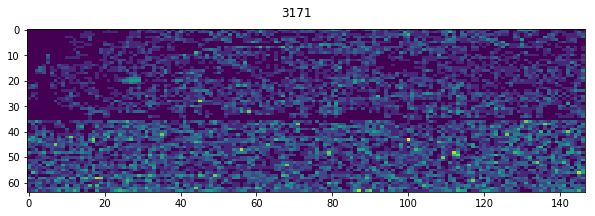

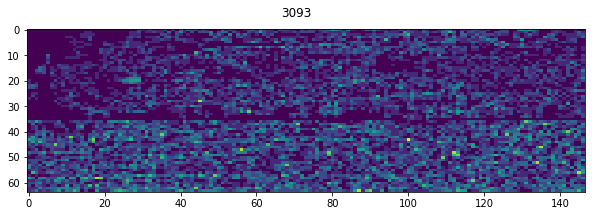

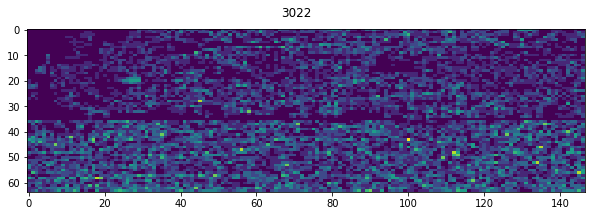

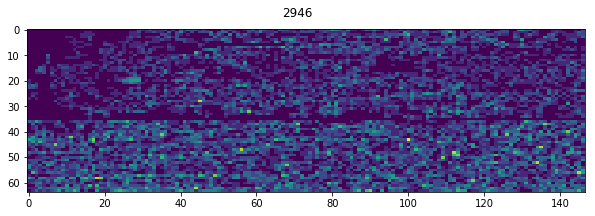

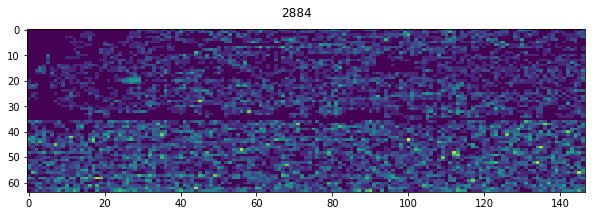

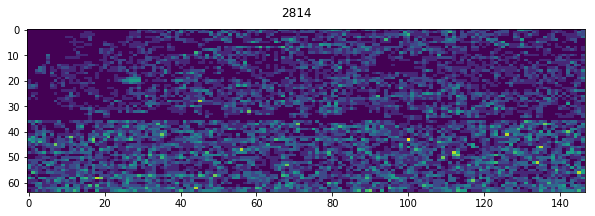

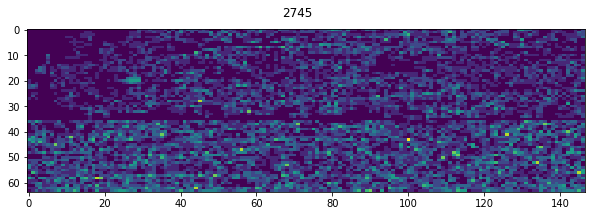

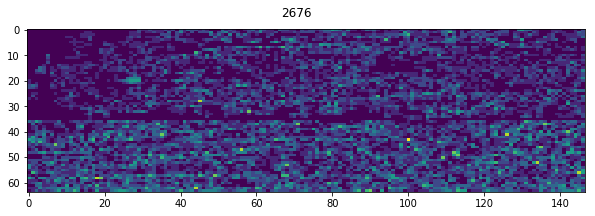

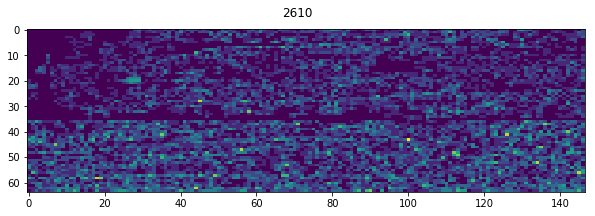

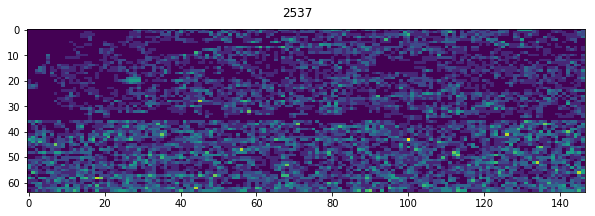

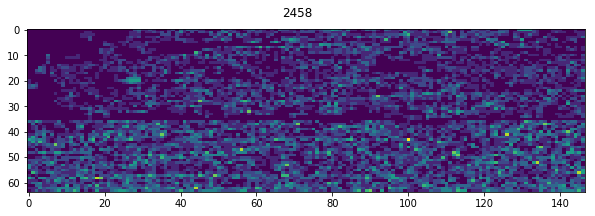

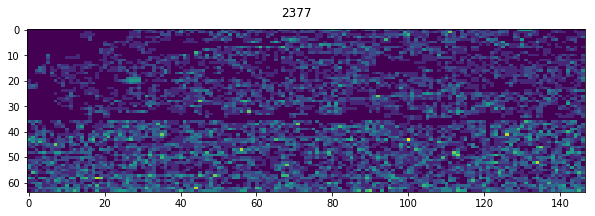

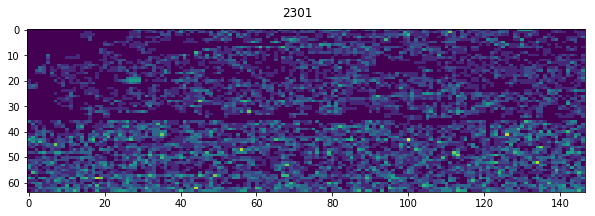

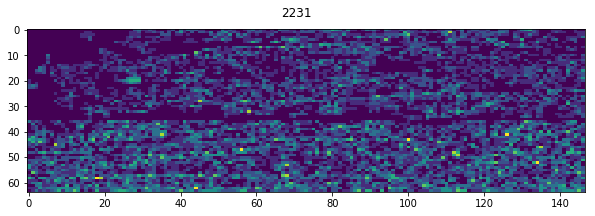

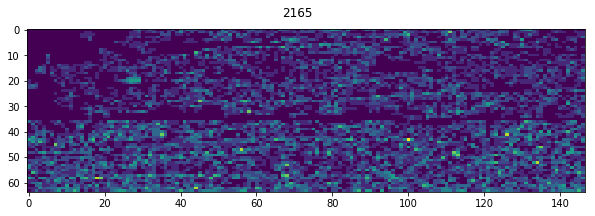

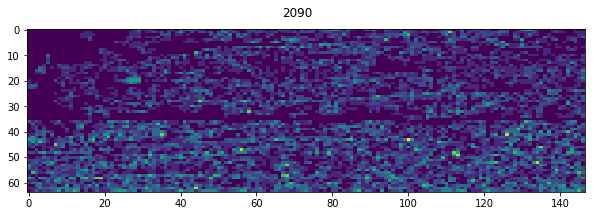

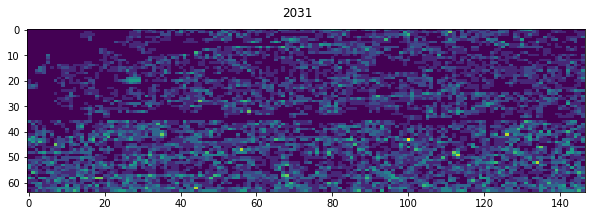

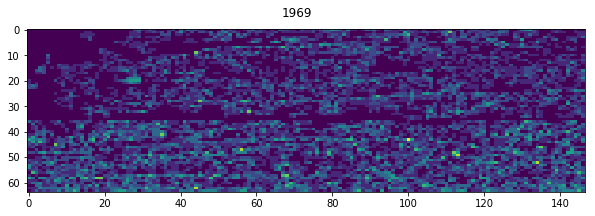

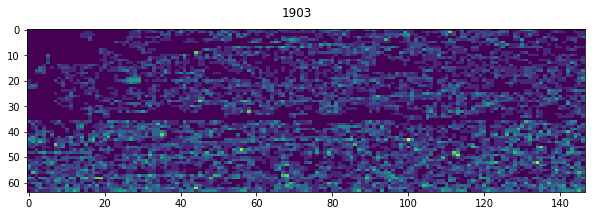

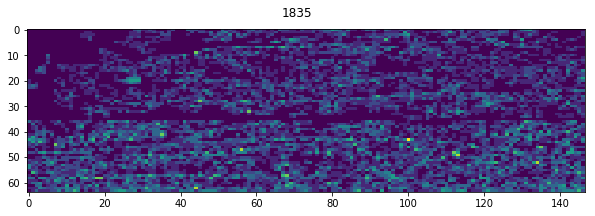

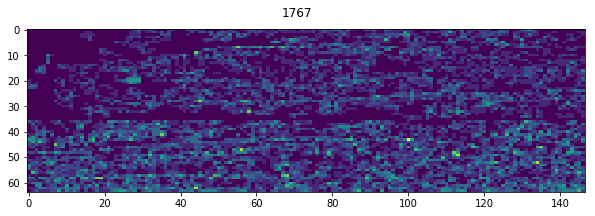

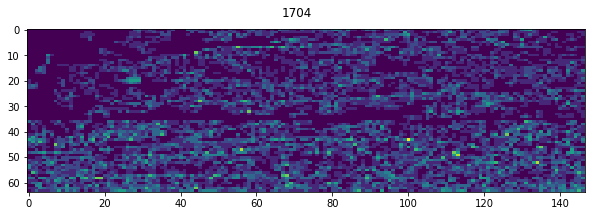

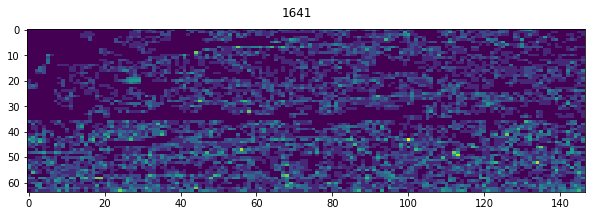

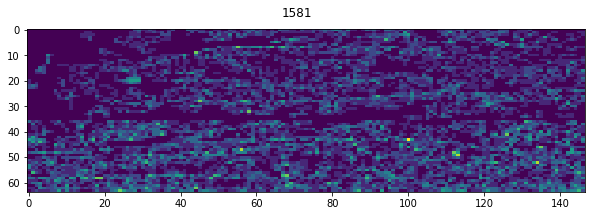

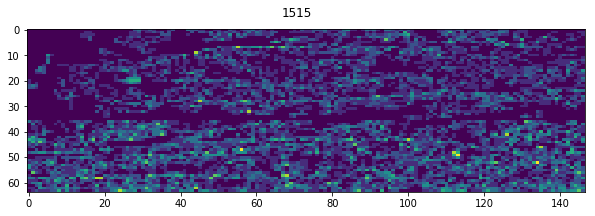

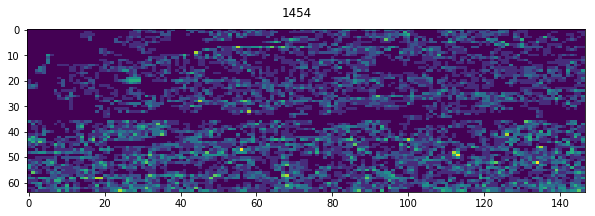

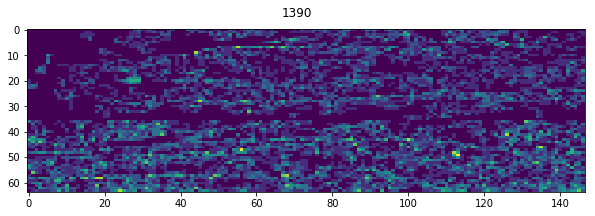

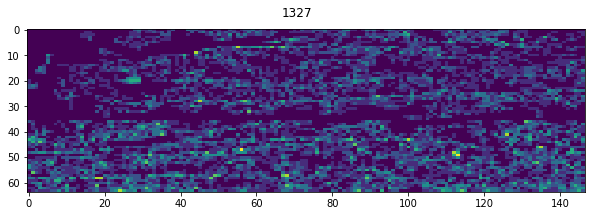

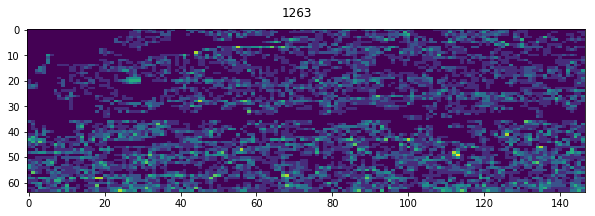

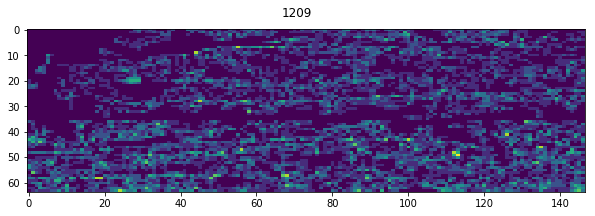

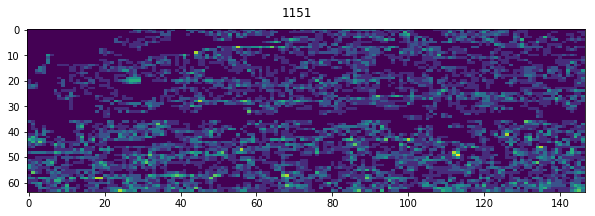

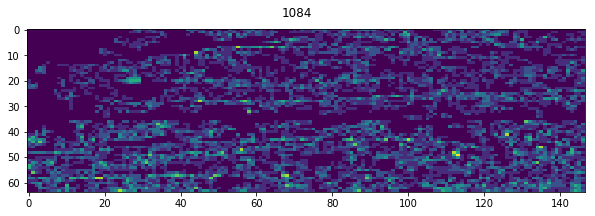

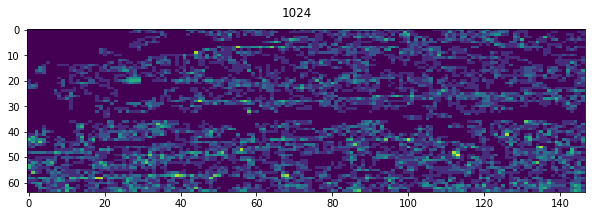

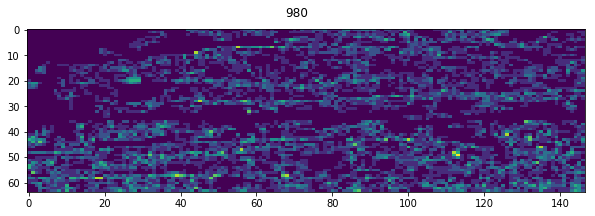

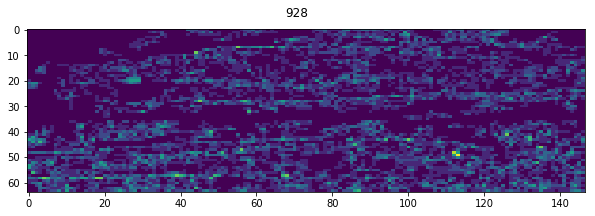

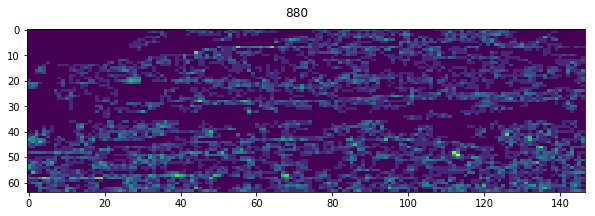

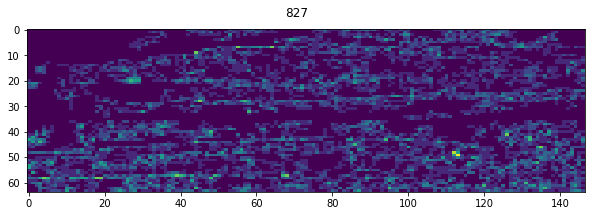

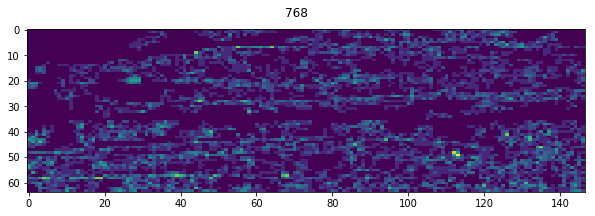

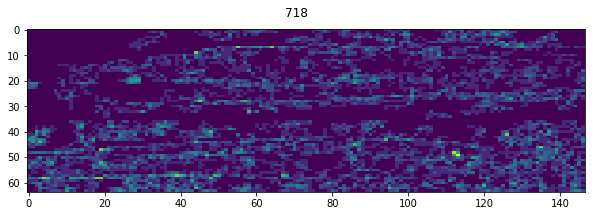

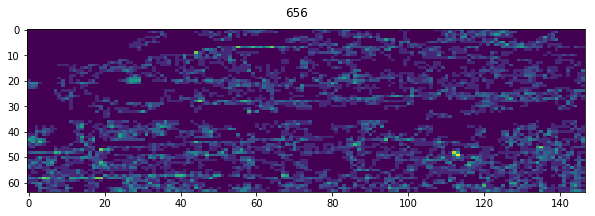

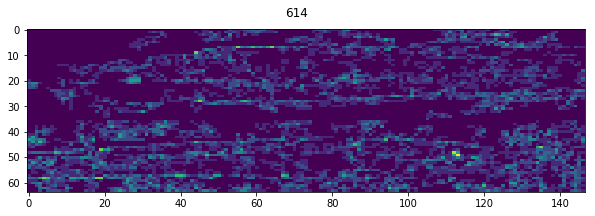

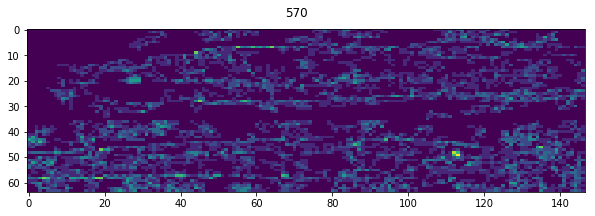

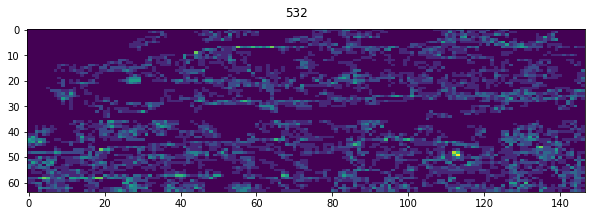

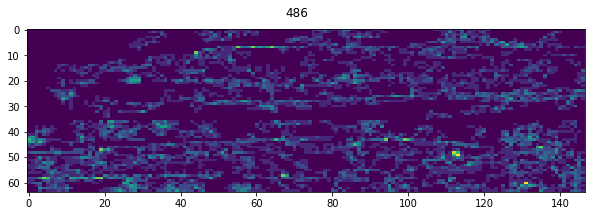

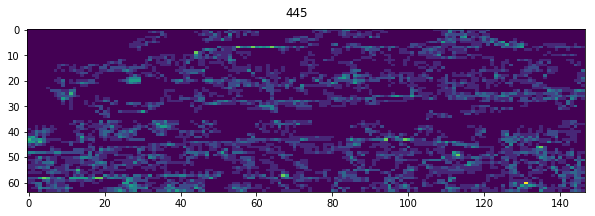

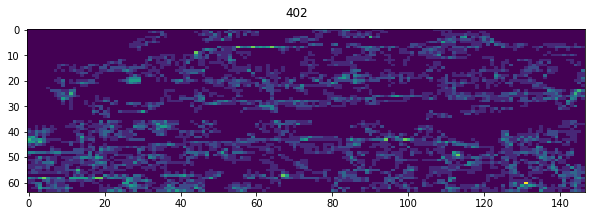

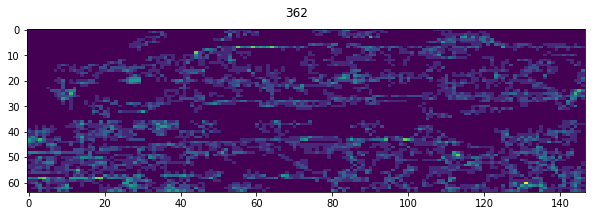

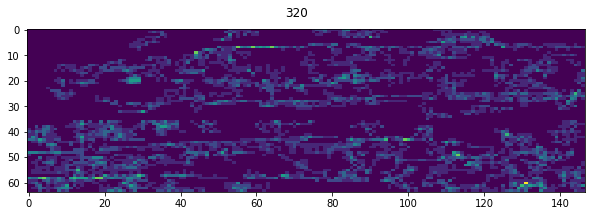

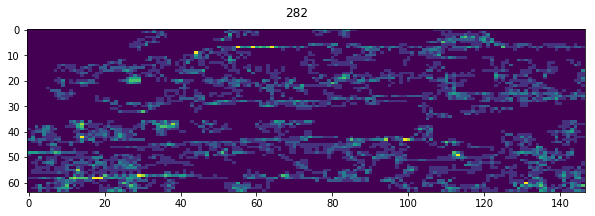

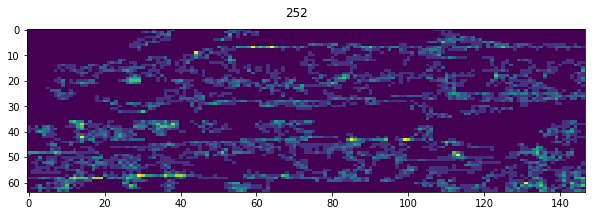

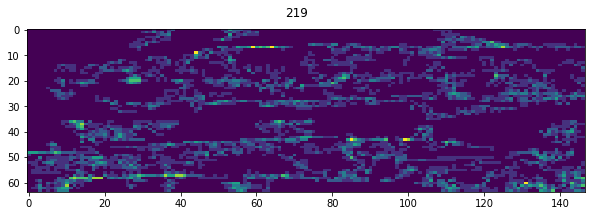

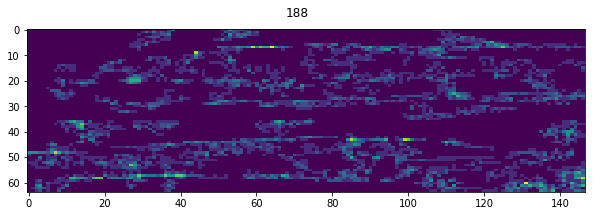

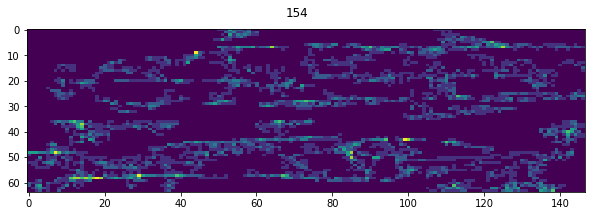

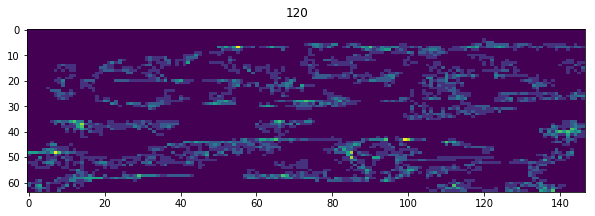

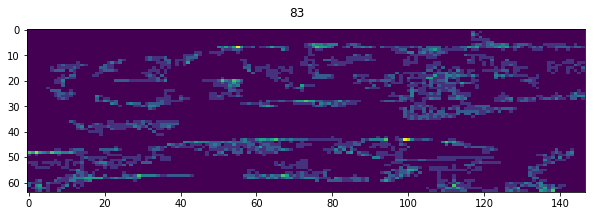

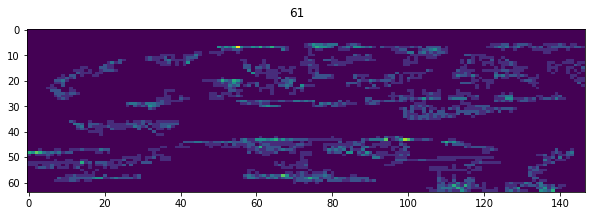

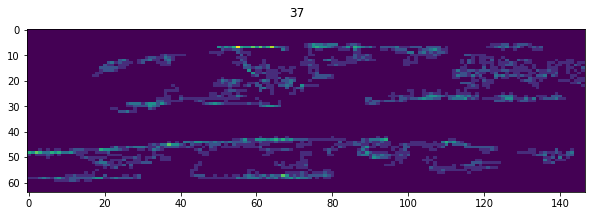

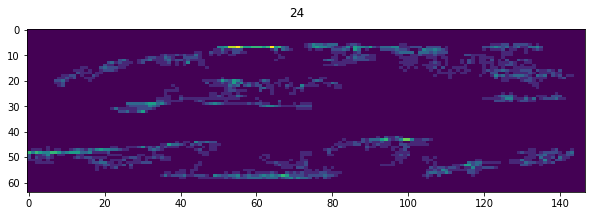

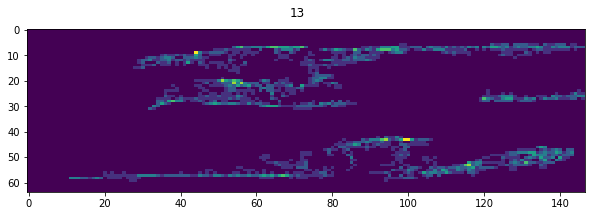

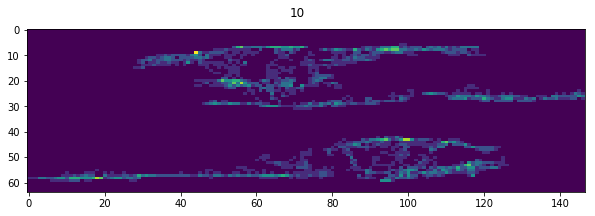

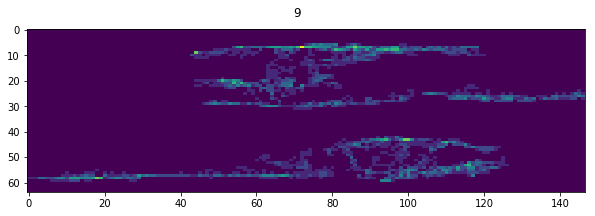

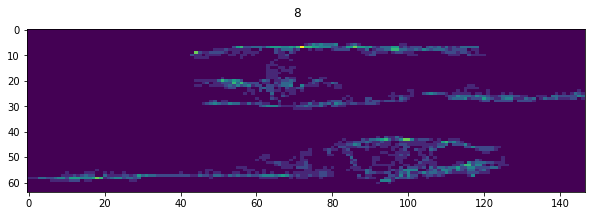

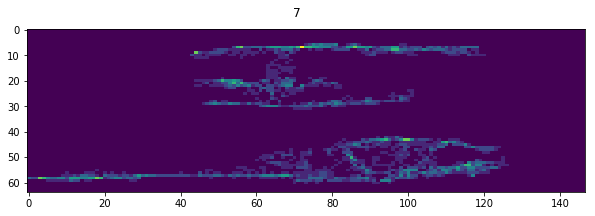

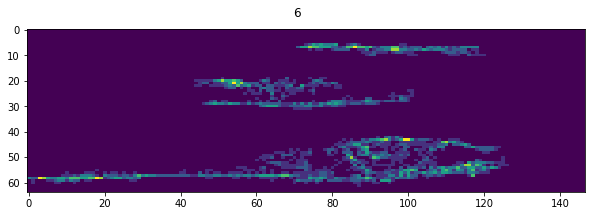

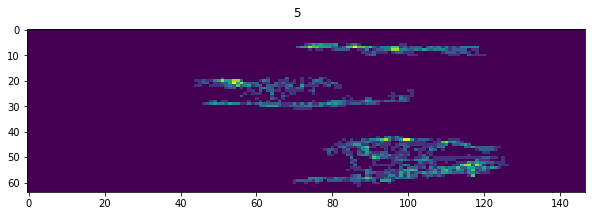

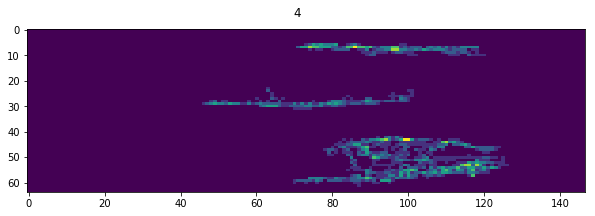

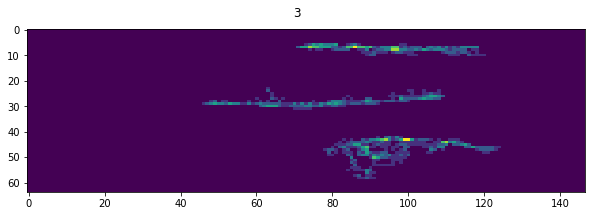

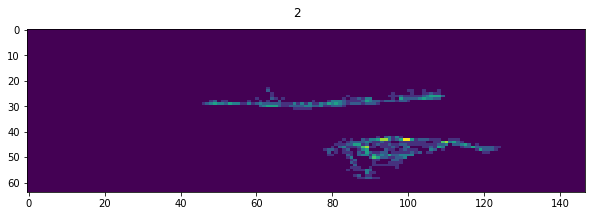

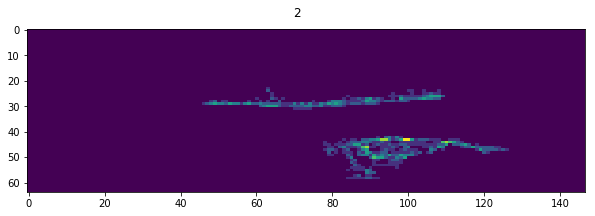

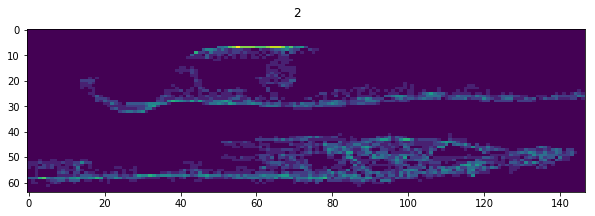

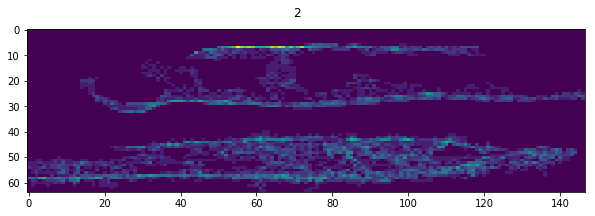

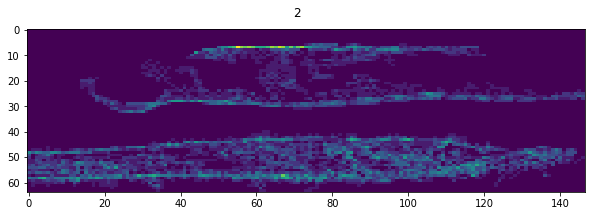

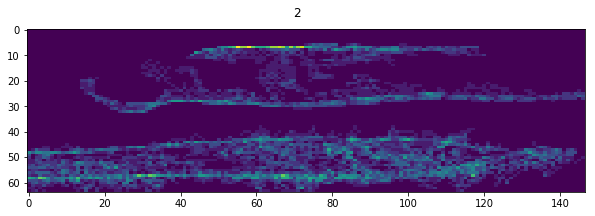

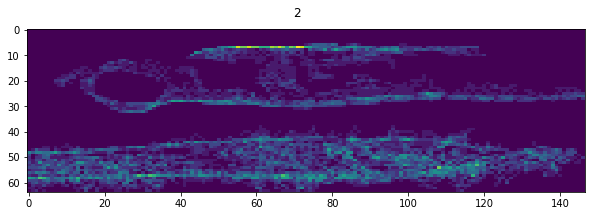

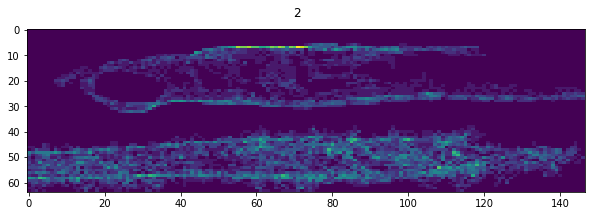

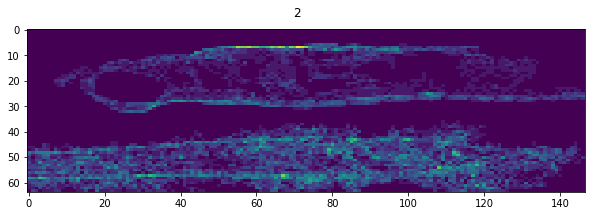

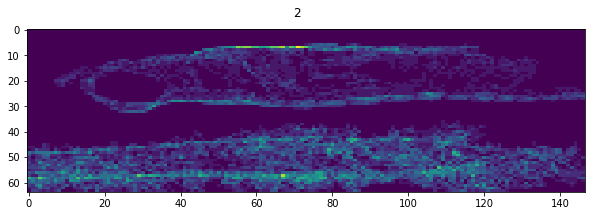

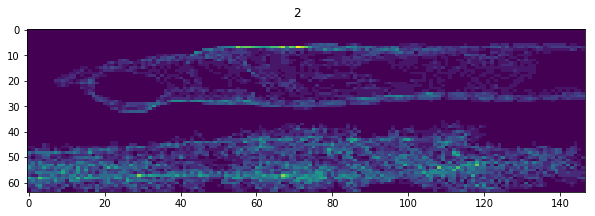

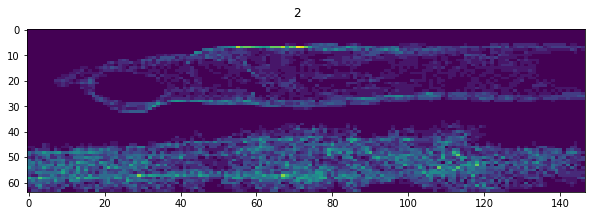

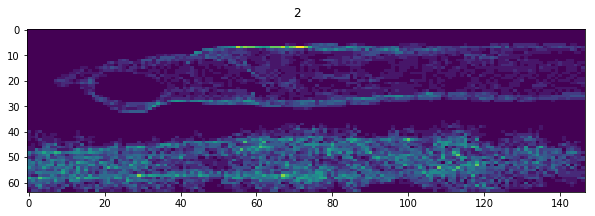

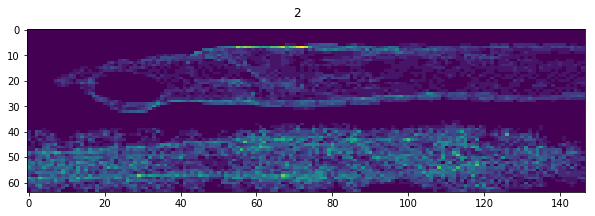

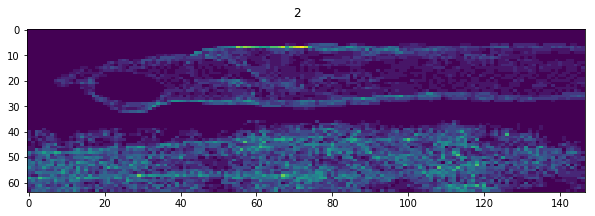

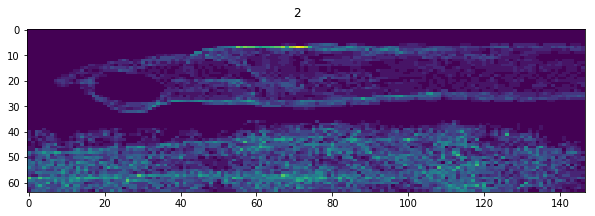

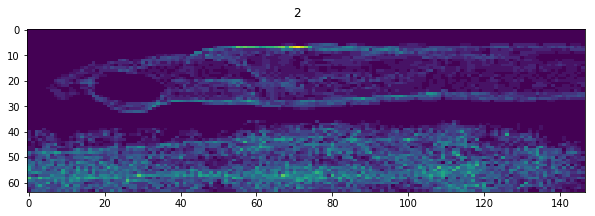

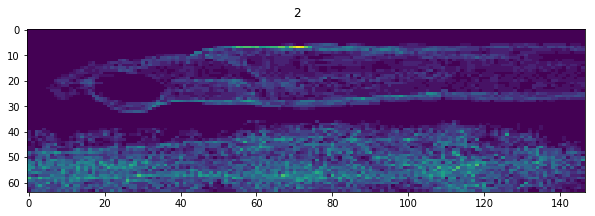

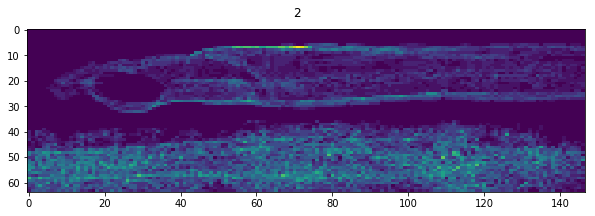

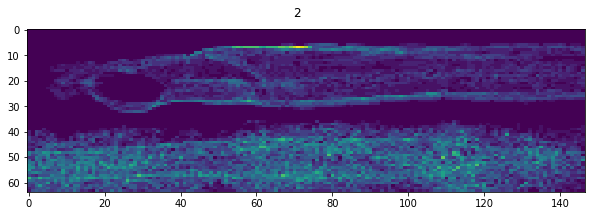

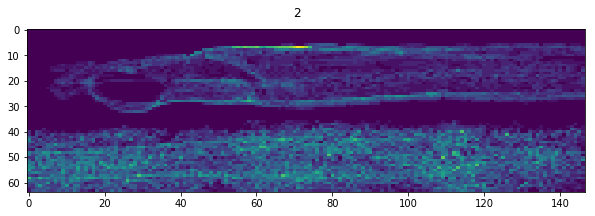

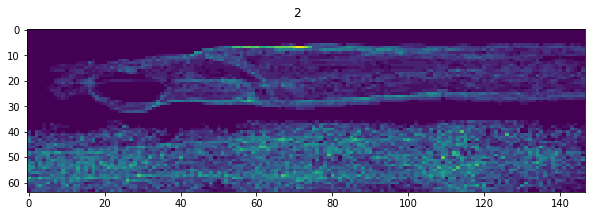

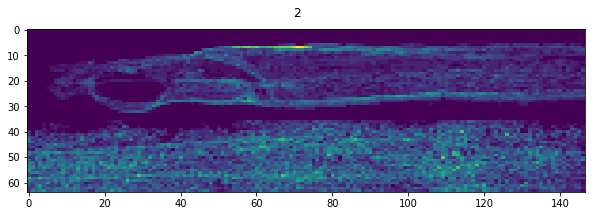

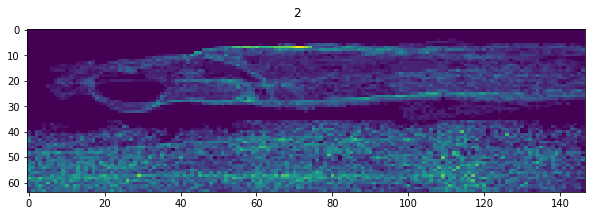

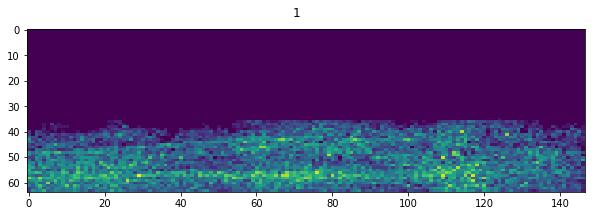

In [10]:
count=0
n=2
display_set=set([])
# until n-1 branches are left
while len(np.unique(topological_array))>2 and len(maximum_set)>n-1:
# while count<10:
    lala=topological_array.copy()
    w_save=w.copy()
    max_save=maximum_set.copy()
#     we remove some branch at each time
    w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict=single_tree_simplification(w,sorted_x,inverse_dict,maximum_set,topological_array,parent_dict,a)
    count+=1
    if count%100==0 or len(maximum_set)<=10 and len(maximum_set) not in display_set:
        display_set.add(len(maximum_set))
        print(len(np.unique(topological_array)),len(sorted_x),len(maximum_set))
        bb=np.zeros(topological_array.shape)
        for i in range(topological_array.shape[0]):
            for j in range(topological_array.shape[1]):
                for k in range(topological_array.shape[2]):
                    if topological_array[i,j,k] in maximum_set:
                        bb[i,j,k]=1
        fig, ax = plt.subplots(figsize=(10,3))
        fig.suptitle(len(maximum_set))
#         ax.imshow(bb[:,:,0],aspect="auto")
        ax.imshow(np.mean(bb,axis=-1),aspect="auto",)

print("Max Nb ",len(maximum_set))
print("Unique Nb ",len(np.unique(topological_array)))

11937
11238


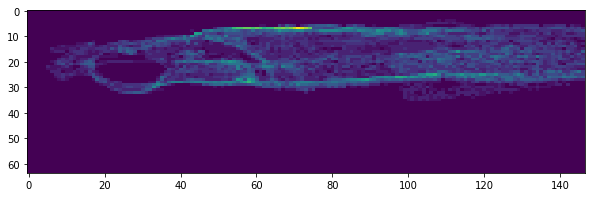

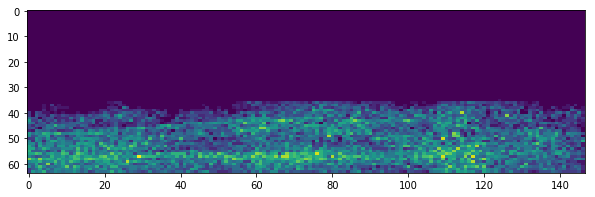

In [11]:
# we display the branches that are left
for i in max_save:
    print(i)
    q=np.zeros(topological_array.shape)
    q[lala==i]=1
    fig, ax = plt.subplots(figsize=(10,3))
    ax.imshow(np.mean(q,axis=-1),aspect="auto")